# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Anna Cheyette

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [4]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

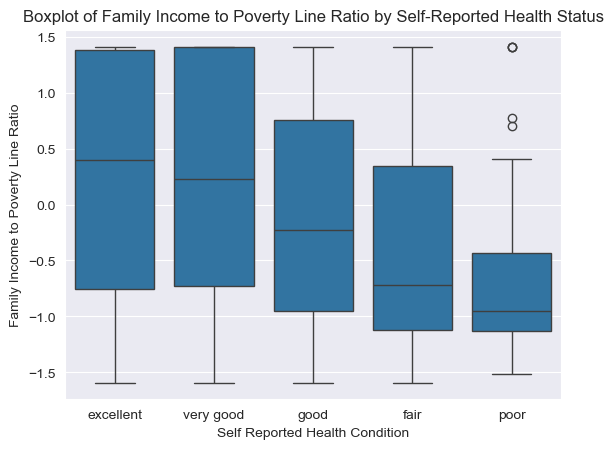

In [5]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

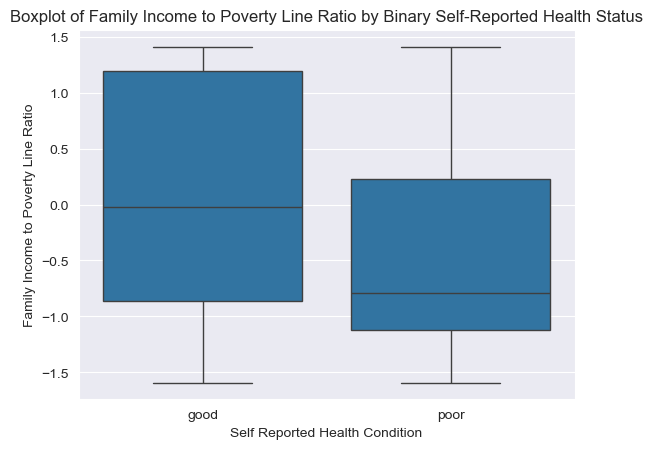

In [6]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

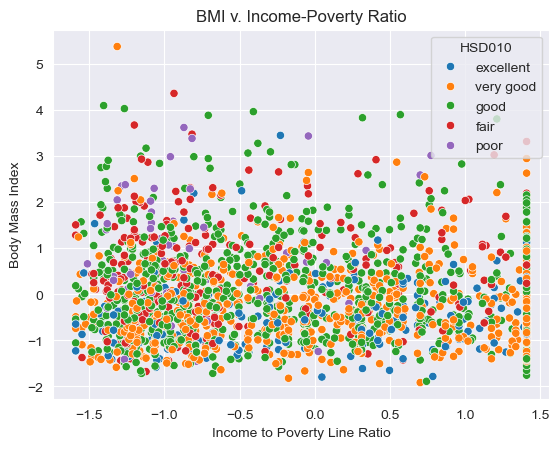

In [7]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [8]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

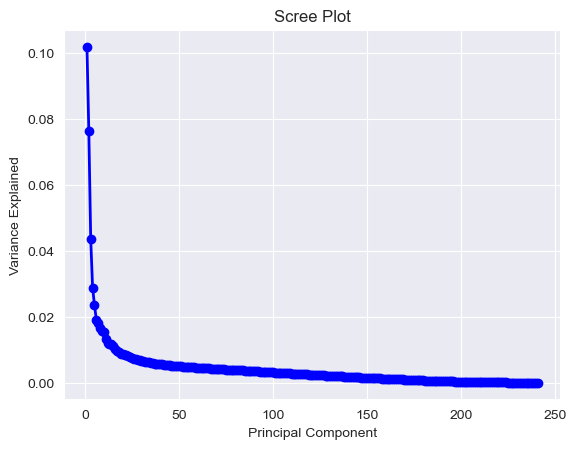

In [9]:
## Your Answer Here
# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(nhanes_scaled)

# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Based on this plot, we can see a drop-off or "elbow" around components 5-10. Based on this plot, I will select 8 components. 

### Barplot of Components

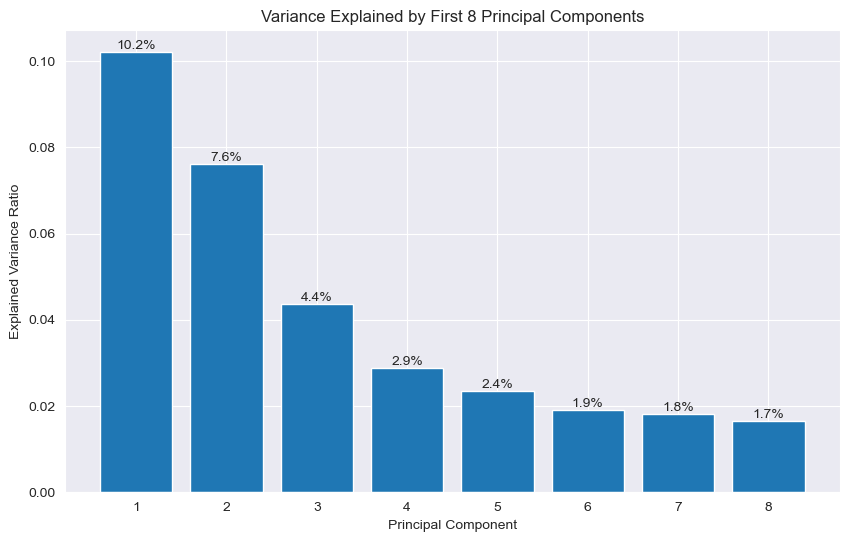

Total variance explained by 8 components: 32.8%


In [10]:
# Perform PCA with 8 components
pca_components = PCA(n_components=8)
pca_val = pca_components.fit_transform(nhanes_scaled)

# Create barplot of explained variance ratios
plt.figure(figsize=(10, 6))
plt.bar(range(1, 9), pca_components.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by First 8 Principal Components')
plt.xticks(range(1, 9))  

# Add percentage labels on top of each bar
for i, v in enumerate(pca_components.explained_variance_ratio_):
    plt.text(i + 1, v, f'{v:.1%}', ha='center', va='bottom')

plt.show()

# Print total variance explained by 8 components
print(f"Total variance explained by 8 components: {sum(pca_components.explained_variance_ratio_):.1%}")

### How many components will you use to fit a supervised learning model?

I'll select 8 components, based on the scree plot.

### 2D Scatterplot of the first two components

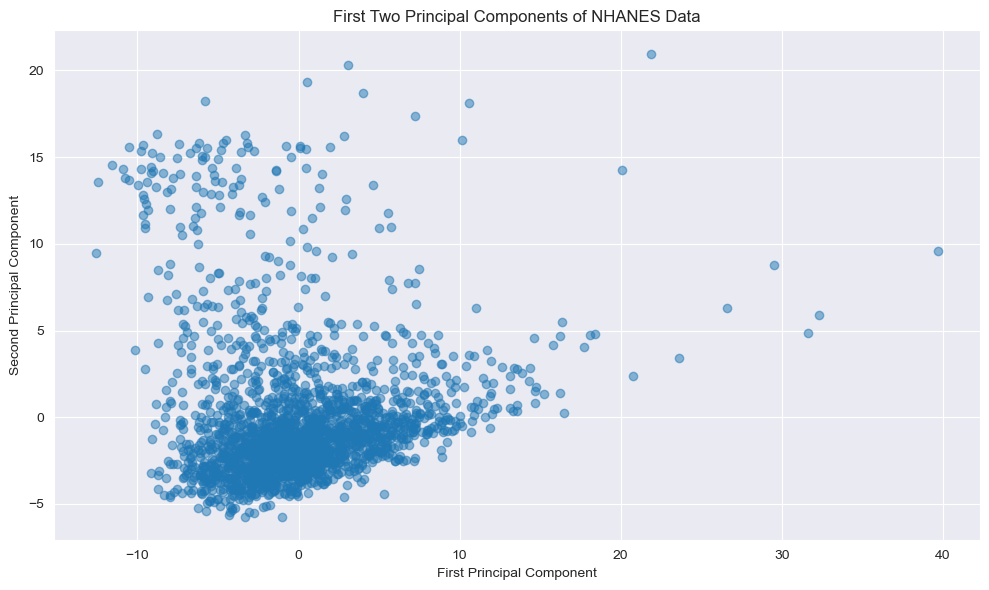

In [11]:
# Create scatter plot of first two components
plt.figure(figsize=(10, 6))
plt.scatter(pca_val[:, 0], pca_val[:, 1], alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('First Two Principal Components of NHANES Data')

# Add a tight layout to prevent label cutoff
plt.tight_layout()
plt.show()

The data shows a dense central cluster, centered around (0,0), which is expected due to the standardization of the data. The first principal component (x-axis) shows a wider range (-10 to 40) than the second component (y-axis, roughly -5 to 20), which confirms that PC1 captures more variance in the data than PC2.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

K-means clustering is a method that groups data points into a specified number (k) of clusters by iteratively assigning each point to the nearest cluster center and then updating these centers based on the mean of all points in each cluster. The goal is to minimize the total distance between points and their cluster centers, resulting in groups where data points within each cluster are more similar to each other than to points in other clusters.

### Cluster nhanes

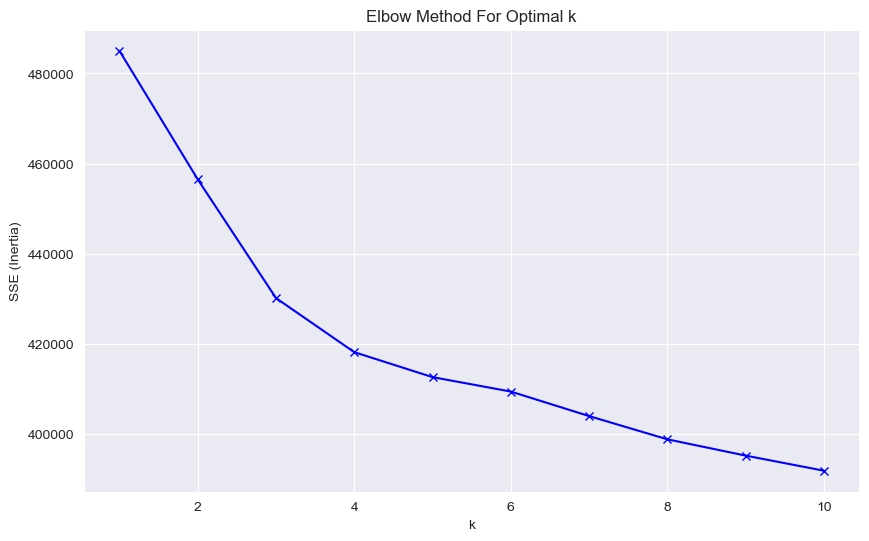

In [12]:
# 1. First, let's find optimal number of clusters using elbow method
inertias = []
K = range(1, 11)  # Testing k from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(nhanes_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on the elbow method plot, I will use k=4.

In [13]:
# Perform k-means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=10)
kmeans_clusters = kmeans.fit_predict(nhanes_scaled)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

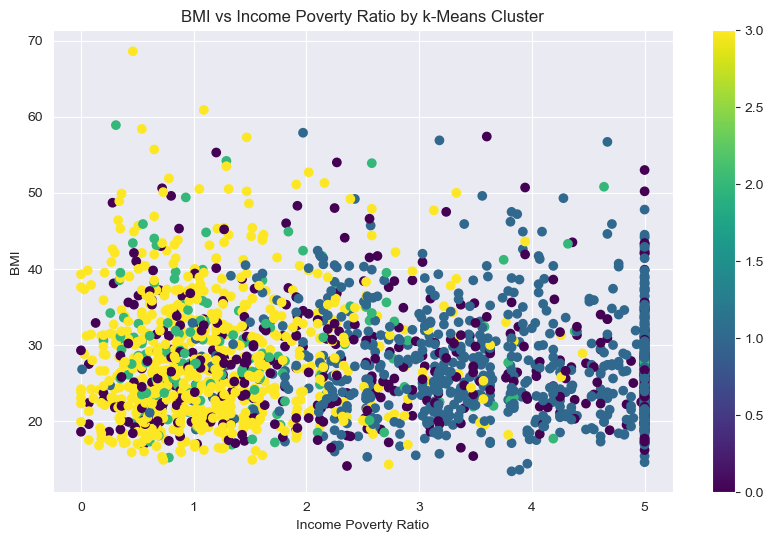

In [14]:
## Your Answer Here
# Plot clusters on BMI vs Income Poverty Ratio
plt.figure(figsize=(10, 6))
scatter = plt.scatter(nhanes['INDFMPIR'], nhanes['BMXBMI'], 
                     c=kmeans_clusters, cmap='viridis')
plt.xlabel('Income Poverty Ratio')
plt.ylabel('BMI')
plt.title('BMI vs Income Poverty Ratio by k-Means Cluster')
plt.colorbar(scatter)
plt.show()

The clusters appear somewhat mixed and overlapping, suggesting that BMI and income poverty ratio alone don't fully explain the clustering patterns found in the full dataset.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

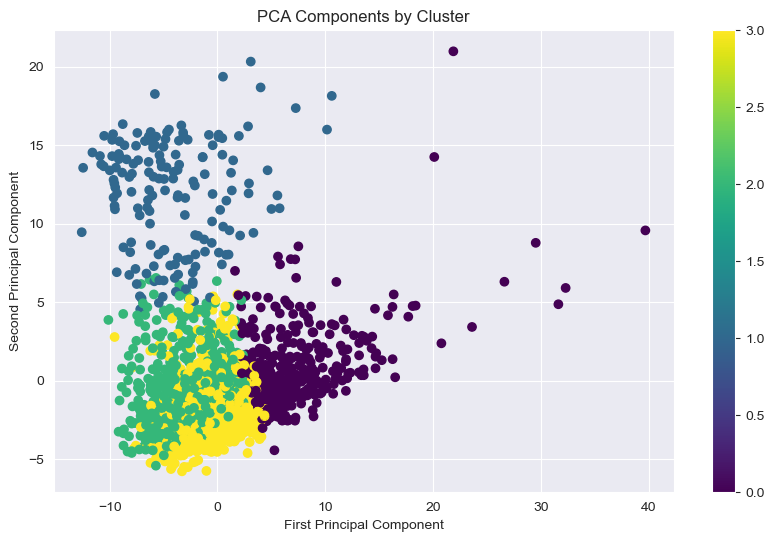

In [15]:
# Cluster using PCA results
kmeans_pca = KMeans(n_clusters=4, random_state=10)
clusters_pca = kmeans_pca.fit_predict(pca_val)

# Plot clusters on first two PCA components
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_val[:, 0], pca_val[:, 1], 
                     c=clusters_pca, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Components by Cluster')
plt.colorbar(scatter)
plt.show()

The clusters are much more distinctly separated in the PCA plot than in the initial k-means, which makes sense as PCA captures the most important variations in the full dataset. This approach allows us to find clusters based on the most important patterns in the data (captured by PCA) rather than using all original variables.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [16]:
# partition data
# -----------

num_classes = 2
# convert to numeric
hsd010_binary = hsd010_binary.replace(['good', 'poor'], [0, 1])
y = hsd010_binary # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 

X = nhanes_scaled # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

/var/folders/_1/m0sq7yvd6lx8srw1yzkxmlk40000gn/T/ipykernel_50037/4231602415.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hsd010_binary = hsd010_binary.replace(['good', 'poor'], [0, 1])


In [17]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [18]:
# create neural network model
# -----------
model = Sequential()

# Input layer
model.add(Dense(64, 
                input_dim=X_train.shape[1],  
                kernel_initializer='normal', 
                activation='relu'))

# Output layer
model.add(Dense(num_classes, 
                kernel_initializer='normal',
                activation='softmax'))  

# Compile model
model.compile(loss='categorical_crossentropy',  
             optimizer='adam',  
             metrics=['accuracy'])  

# Fit model
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=50,
          batch_size=32,
          verbose=2)

/opt/anaconda3/envs/CSS/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
49/49 - 1s - 19ms/step - accuracy: 0.8404 - loss: 0.4435 - val_accuracy: 0.8469 - val_loss: 0.3635
Epoch 2/50
49/49 - 0s - 2ms/step - accuracy: 0.8747 - loss: 0.3170 - val_accuracy: 0.8721 - val_loss: 0.3416
Epoch 3/50
49/49 - 0s - 2ms/step - accuracy: 0.8889 - loss: 0.2720 - val_accuracy: 0.8702 - val_loss: 0.3366
Epoch 4/50
49/49 - 0s - 2ms/step - accuracy: 0.9070 - loss: 0.2306 - val_accuracy: 0.8682 - val_loss: 0.3365
Epoch 5/50
49/49 - 0s - 2ms/step - accuracy: 0.9225 - loss: 0.1960 - val_accuracy: 0.8702 - val_loss: 0.3444
Epoch 6/50
49/49 - 0s - 2ms/step - accuracy: 0.9412 - loss: 0.1638 - val_accuracy: 0.8624 - val_loss: 0.3508
Epoch 7/50
49/49 - 0s - 2ms/step - accuracy: 0.9528 - loss: 0.1374 - val_accuracy: 0.8585 - val_loss: 0.3667
Epoch 8/50
49/49 - 0s - 2ms/step - accuracy: 0.9606 - loss: 0.1122 - val_accuracy: 0.8488 - val_loss: 0.3995
Epoch 9/50
49/49 - 0s - 2ms/step - accuracy: 0.9716 - loss: 0.0953 - val_accuracy: 0.8605 - val_loss: 0.3947
Epoch 10/50
49/49 

### Neural Network on Principal Components

In [19]:
# Split the PCA transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(pca_val, 
                                                            y, 
                                                            test_size=0.25, 
                                                            random_state=10)

num_classes = 2  
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Create neural network model
model_pca = Sequential()

# Input layer 
model_pca.add(Dense(64, 
                   input_dim=8,  # number of PCA components
                   kernel_initializer='normal', 
                   activation='relu'))

# Output layer
model_pca.add(Dense(num_classes, 
                   kernel_initializer='normal',
                   activation='softmax'))

# Compile model
model_pca.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

# Fit model
history_pca = model_pca.fit(X_train_pca, y_train,
                           validation_data=(X_test_pca, y_test),
                           epochs=50,
                           batch_size=32,
                           verbose=2)

Epoch 1/50


/opt/anaconda3/envs/CSS/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 - 1s - 18ms/step - accuracy: 0.7907 - loss: 0.5476 - val_accuracy: 0.8527 - val_loss: 0.4288
Epoch 2/50
49/49 - 0s - 2ms/step - accuracy: 0.8527 - loss: 0.3927 - val_accuracy: 0.8469 - val_loss: 0.3772
Epoch 3/50
49/49 - 0s - 2ms/step - accuracy: 0.8514 - loss: 0.3669 - val_accuracy: 0.8508 - val_loss: 0.3705
Epoch 4/50
49/49 - 0s - 2ms/step - accuracy: 0.8566 - loss: 0.3618 - val_accuracy: 0.8469 - val_loss: 0.3687
Epoch 5/50
49/49 - 0s - 2ms/step - accuracy: 0.8559 - loss: 0.3587 - val_accuracy: 0.8469 - val_loss: 0.3672
Epoch 6/50
49/49 - 0s - 2ms/step - accuracy: 0.8598 - loss: 0.3567 - val_accuracy: 0.8469 - val_loss: 0.3682
Epoch 7/50
49/49 - 0s - 2ms/step - accuracy: 0.8566 - loss: 0.3548 - val_accuracy: 0.8527 - val_loss: 0.3651
Epoch 8/50
49/49 - 0s - 2ms/step - accuracy: 0.8572 - loss: 0.3522 - val_accuracy: 0.8547 - val_loss: 0.3642
Epoch 9/50
49/49 - 0s - 2ms/step - accuracy: 0.8637 - loss: 0.3510 - val_accuracy: 0.8508 - val_loss: 0.3646
Epoch 10/50
49/49 - 0s - 2ms/

### Neural Network on Principal Components + Cluster Membership

In [20]:
# Convert clusters to one-hot encoded format
clusters_onehot = keras.utils.to_categorical(clusters_pca)

# Combine PCA components and cluster membership
X_combined = np.hstack([pca_val, clusters_onehot])

# Split the combined data
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, 
                                                                      y, 
                                                                      test_size=0.25, 
                                                                      random_state=10)

# Convert target to categorical
num_classes = 2  # binary classification
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Create neural network model
model_combined = Sequential()

# Input layer (note: input_dim is now 8 PCA components + 4 cluster dummy variables = 10)
model_combined.add(Dense(64, 
                        input_dim=X_train_combined.shape[1],  
                        kernel_initializer='normal', 
                        activation='relu'))

# Output layer
model_combined.add(Dense(num_classes, 
                        kernel_initializer='normal',
                        activation='softmax'))

# Compile model
model_combined.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

# Fit model
history_combined = model_combined.fit(X_train_combined, y_train,
                                    validation_data=(X_test_combined, y_test),
                                    epochs=50,
                                    batch_size=32,
                                    verbose=2)

Epoch 1/50
49/49 - 1s - 16ms/step - accuracy: 0.8269 - loss: 0.5115 - val_accuracy: 0.8469 - val_loss: 0.3990
Epoch 2/50
49/49 - 0s - 2ms/step - accuracy: 0.8540 - loss: 0.3761 - val_accuracy: 0.8566 - val_loss: 0.3654
Epoch 3/50
49/49 - 0s - 2ms/step - accuracy: 0.8553 - loss: 0.3603 - val_accuracy: 0.8527 - val_loss: 0.3639
Epoch 4/50
49/49 - 0s - 2ms/step - accuracy: 0.8572 - loss: 0.3569 - val_accuracy: 0.8585 - val_loss: 0.3605
Epoch 5/50
49/49 - 0s - 2ms/step - accuracy: 0.8566 - loss: 0.3537 - val_accuracy: 0.8547 - val_loss: 0.3624
Epoch 6/50
49/49 - 0s - 2ms/step - accuracy: 0.8630 - loss: 0.3511 - val_accuracy: 0.8605 - val_loss: 0.3606
Epoch 7/50
49/49 - 0s - 2ms/step - accuracy: 0.8566 - loss: 0.3499 - val_accuracy: 0.8624 - val_loss: 0.3597
Epoch 8/50
49/49 - 0s - 2ms/step - accuracy: 0.8630 - loss: 0.3487 - val_accuracy: 0.8605 - val_loss: 0.3589
Epoch 9/50
49/49 - 0s - 2ms/step - accuracy: 0.8611 - loss: 0.3470 - val_accuracy: 0.8605 - val_loss: 0.3602
Epoch 10/50
49/49 

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA is a technique that takes many variables and combines them into a smaller number of new variables that still capture the main patterns in the data. Clustering, on the other hand, is a method that groups similar data points together into clusters, trying to find natural groupings in the data. While PCA helps us simplify our data by reducing the number of variables, clustering helps us understand how our observations naturally group together.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Combining PCA and clustering showed advantages in how PCA helped reveal clear cluster patterns in the visualization where we saw distinct group separation (especially the yellow cluster). Using both PCA components and cluster assignments as features for the neural network allowed us to achieve strong performance with a validation accuracy of around 86% and relatively stable training. 

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques like PCA and clustering can help with supervised learning tasks on big data by reducing dimensionality and finding important patterns before training the main model. These techniques can make the learning process more efficient by reducing noise and computational complexity, while still maintaining the most important information in the data - for example, in our analysis, we reduced many NHANES variables down to just 6 PCA components plus 4 cluster assignments, while still achieving good prediction accuracy on health status.